# Data Exploration 

In [1]:
import pandas as pd
import numpy as np
import io
import sys
import os
import matplotlib.pyplot as plt

In [2]:
import boto3
import sagemaker

In [3]:
s3_client = boto3.client('s3')
bucket_name = 'wildfires'

In [4]:
obj_list=s3_client.list_objects(Bucket=bucket_name)
files=[]
for contents in obj_list['Contents']:
    files.append(contents['Key'])
    
print(files)

['Fires2.pkl']


In [5]:
file_name = files[0]
data_object = s3_client.get_object(Bucket=bucket_name, Key=file_name)

In [6]:
data_body = data_object["Body"].read()

In [7]:
data_stream = io.BytesIO(data_body)
df = pd.read_pickle(data_stream)

In [8]:
df.head(5)

,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,LATITUDE,LONGITUDE,FIRE_SIZE,FIRE_SIZE_CLASS,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,STATE
0,2005,2453403.5,33,1300,40.036944,-121.005833,0.10,A,9.0,Miscellaneous,CA
1,2004,2453137.5,133,0845,38.933056,-120.404444,0.25,A,1.0,Lightning,CA
2,2004,2453156.5,152,1921,38.984167,-120.735556,0.10,A,5.0,Debris Burning,CA
3,2004,2453184.5,180,1600,38.559167,-119.913333,0.10,A,1.0,Lightning,CA
4,2004,2453184.5,180,1600,38.559167,-119.933056,0.10,A,1.0,Lightning,CA


In [9]:
df.columns

Index(['FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'DISCOVERY_TIME',
       'LATITUDE', 'LONGITUDE', 'FIRE_SIZE', 'FIRE_SIZE_CLASS',
       'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'STATE'],
      dtype='object')

### Exploratory visualization, histograms of some features

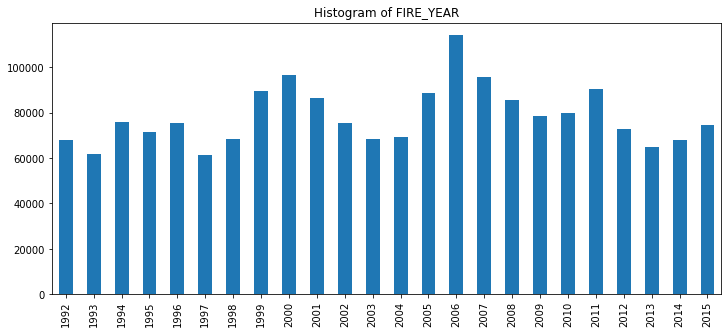

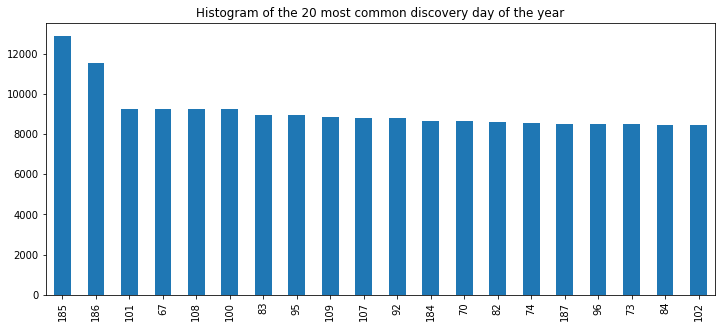

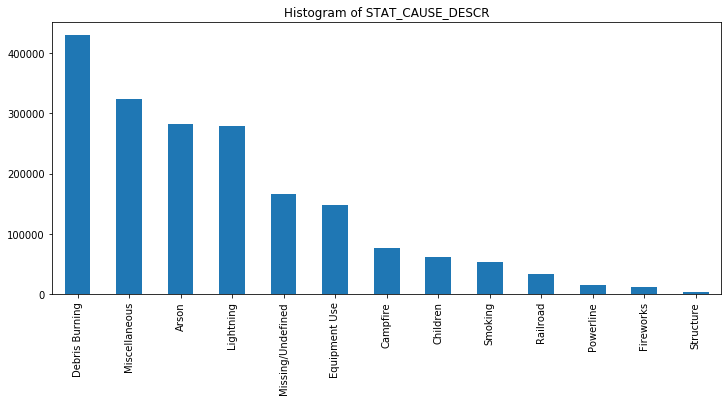

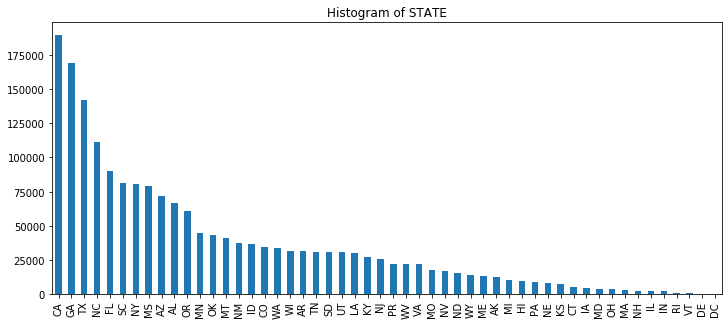

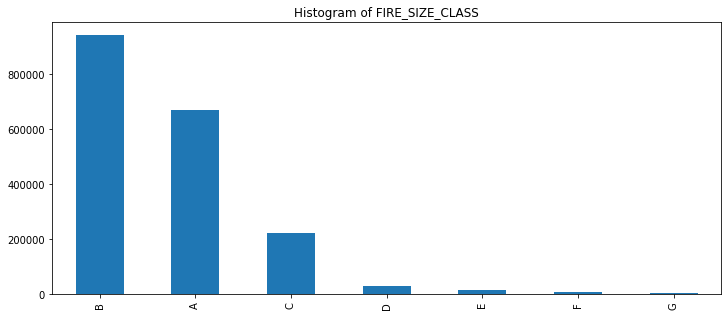

In [10]:
# Columns to study
columns_list = ['FIRE_YEAR','DISCOVERY_DOY', 'STAT_CAUSE_DESCR', 'STATE', 'FIRE_SIZE_CLASS']

for column_name in columns_list:
    ax=plt.subplots(figsize=(6,3))
    # get data by column_name and display a histogram
    if column_name not in {'DISCOVERY_DOY','FIRE_YEAR'} :
        ax = df[column_name].value_counts().plot(kind='bar', figsize=(12,5))
        title="Histogram of " + column_name
    elif column_name == 'DISCOVERY_DOY':
        df['DISCOVERY_DOY'].value_counts()[:20].plot(kind='bar', figsize=(12,5))
        title="Histogram of the 20 most common discovery day of the year"
    else: 
        df['FIRE_YEAR'].value_counts().sort_index().plot(kind='bar', figsize=(12,5))
        title="Histogram of " + column_name
    plt.title(title, fontsize=12)
    plt.savefig(os.path.join('wildfire_data',column_name + "_hist.png"))
    plt.show()

From the above histogram, we can see a few interesting facts about Wildfires in the US: 
* California is the state with more wildfires from 1992 to 2015. Followed by Georgi and Texas.
* Debris burning is the most common causes. Also from the histogram of causes, we corroborate that the data is highly umbalanced.
* 185 and 186 are the day of the year where more wildfires are discovered, which makes sense as these occur in July month, which is ussually one of the warmest month of the year. 
* 2006 is the year where more Wildfires were discovered. 

Checking the year 2006. TO DO: Why more Wildfires in 2006? 

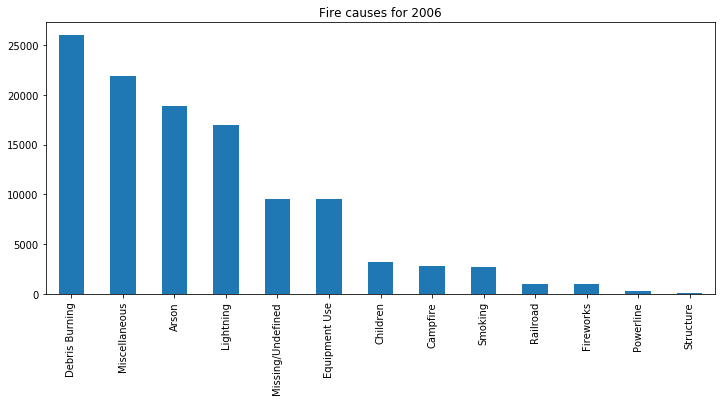

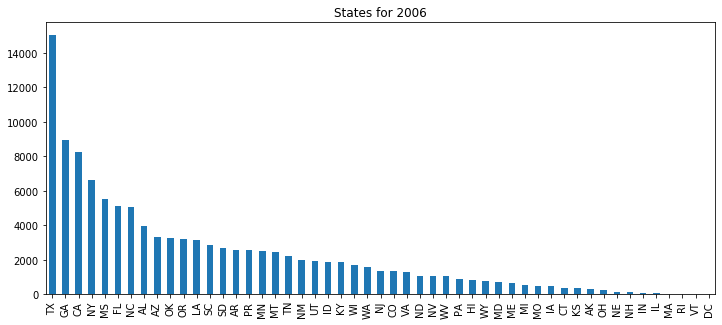

In [12]:
outlier_year = 2006
df['STAT_CAUSE_DESCR'][df['FIRE_YEAR']==outlier_year].value_counts().plot(kind='bar', figsize=(12,5))
plt.title("Fire causes for "+ str(outlier_year), fontsize=12)
plt.show()
df['STATE'][df['FIRE_YEAR']==outlier_year].value_counts().plot(kind='bar', figsize=(12,5))
plt.title("States for "+ str(outlier_year), fontsize=12)
plt.savefig(os.path.join('wildfire_data', "states_2006_hist.png"))
plt.show()

From the graphs above, we can see that wildfire caused by 'Debris burning' happened in [Texas back in 2006](https://www.weather.gov/ama/march2006_wildfire)